In [2]:
import sys, subprocess

print("Using Python:", sys.executable)

# 1) Clean out CPU-only builds
subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y",
                       "torch", "torchvision", "torchaudio"])

# 2) Install CUDA-enabled wheels into THIS env
# If cu124 is unavailable for you, change cu124 -> cu126 (or any cu12x shown on pytorch.org)
subprocess.check_call([sys.executable, "-m", "pip", "install",
                       "--force-reinstall", "--no-cache-dir",
                       "--index-url", "https://download.pytorch.org/whl/cu124",
                       "torch", "torchvision", "torchaudio"])

Using Python: c:\Users\Max\Desktop\ComputerVision\INF3001_Project\.venv\Scripts\python.exe


0

In [3]:
#CELL 1
import os, math, random, json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler, SubsetRandomSampler
from torchvision import datasets, transforms, models
import numpy as np, random
from collections import defaultdict, Counter
# Interpolation fallback (handles different torchvision/PIL versions)
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except Exception:
    from PIL import Image as _PIL_Image
    BICUBIC = _PIL_Image.BICUBIC

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [4]:
# ==== EDIT THIS if your folder isn't "dataset" under the notebook's cwd ====
# e.g. r"C:\Users\Max\Desktop\ComputerVision\INF3001_Project\dataset"
#CELL 2

DATASET_ROOT   = "../dataset"

# ==== no need to touch below (defaults) ====
TRAIN_DIR      = f"{DATASET_ROOT}/train"   # we’ll split this virtually
CHECKPOINT_PATH = "augment_classifier_best.pth"
CLASS_MAP_JSON  = "class_mapping.json"

IMAGE_SIZE   = 224
BATCH_SIZE   = 32
EPOCHS       = 8
LEARNING_RATE= 3e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS  = 2
USE_AMP      = True
VAL_RATIO    = 0.2     # 20% validation from train
SEED         = 42
print("Using DATASET_ROOT:", DATASET_ROOT)
print("CWD:", Path.cwd())
print("Looking for:", Path(TRAIN_DIR).resolve())
print("Exists?", Path(TRAIN_DIR).is_dir())


Using DATASET_ROOT: ../dataset
CWD: c:\Users\Max\Desktop\ComputerVision\INF3001_Project\notebooks
Looking for: C:\Users\Max\Desktop\ComputerVision\INF3001_Project\dataset\train
Exists? True


In [5]:
#CELL 3
# Data augmentation and normalization for training
try:
    from torchvision.transforms import InterpolationMode
    _BICUBIC = InterpolationMode.BICUBIC
except Exception:
    _BICUBIC = _PIL_Image.BICUBIC

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    import torch
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

IM_MEAN = [0.485, 0.456, 0.406]
IM_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7, 1.0), interpolation=_BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=12),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IM_MEAN, IM_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
])

val_tfms = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.15), interpolation=_BICUBIC),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IM_MEAN, IM_STD),
])

print("Transforms ready ✅")


Transforms ready ✅


In [6]:
#CELL 4

root = Path(TRAIN_DIR)
assert root.is_dir(), f"Training directory not found: {root}\n(Does {DATASET_ROOT}/train exist?)"

# Base dataset (to read file list + labels; no transforms here)
base_ds = datasets.ImageFolder(str(root))
labels = [lbl for _, lbl in base_ds.samples]
classes = base_ds.classes
num_classes = len(classes)

# Build stratified indices
by_class = defaultdict(list)
for idx, lbl in enumerate(labels):
    by_class[lbl].append(idx)

rng = random.Random(SEED)
train_idx, val_idx = [], []
for lbl, idxs in by_class.items():
    rng.shuffle(idxs)
    k = max(1, int(len(idxs) * VAL_RATIO))
    val_idx += idxs[:k]
    train_idx += idxs[k:]

# Two datasets pointing to the SAME files but different transforms
train_ds = datasets.ImageFolder(str(root), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(root), transform=val_tfms)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(train_idx),
    num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda")
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE,
    sampler=SubsetRandomSampler(val_idx),
    num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda")
)

# Save class mapping for inference later
idx_to_class = {i: c for i, c in enumerate(classes)}
import json
with open(CLASS_MAP_JSON, "w", encoding="utf-8") as f:
    json.dump(idx_to_class, f, indent=2)

# Summary
cnt_train = Counter(classes[labels[i]] for i in train_idx)
cnt_val   = Counter(classes[labels[i]] for i in val_idx)
print("Classes:", idx_to_class)
print("Train counts:", dict(cnt_train))
print("Val counts:", dict(cnt_val))
print("Loaders ready ✅")


Classes: {0: 'helmet', 1: 'no_helmet'}
Train counts: {'helmet': 648, 'no_helmet': 648}
Val counts: {'helmet': 162, 'no_helmet': 162}
Loaders ready ✅


In [7]:
# Cell 5: Model Training (Modified to Store Losses)
try:
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
except Exception:
    model = models.resnet18(pretrained=True)  # older torchvision fallback
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda" and USE_AMP))

def acc(logits, y): return (logits.argmax(1)==y).float().mean().item()

def train_one_epoch():
    model.train(); tl=ta=n=0
    for x,y in train_loader:
        x=x.to(device,non_blocking=True); y=y.to(device,non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda" and USE_AMP)):
            logits=model(x); loss=criterion(logits,y)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        bs=x.size(0); tl+=loss.item()*bs; ta+=acc(logits,y)*bs; n+=bs
    return tl/n, ta/n

@torch.no_grad()
def evaluate():
    model.eval(); vl=va=n=0
    for x,y in val_loader:
        x=x.to(device,non_blocking=True); y=y.to(device,non_blocking=True)
        logits=model(x); loss=criterion(logits,y)
        bs=x.size(0); vl+=loss.item()*bs; va+=acc(logits,y)*bs; n+=bs
    return vl/n, va/n

# Initialize lists to store losses
train_losses, val_losses = [], []
best = 0.0
for epoch in range(1, EPOCHS+1):
    tl, ta = train_one_epoch()
    vl, va = evaluate()
    train_losses.append(tl)  # Store training loss
    val_losses.append(vl)    # Store validation loss
    print(f"Epoch {epoch:02d}/{EPOCHS} | train {tl:.4f}/{ta:.4f} | val {vl:.4f}/{va:.4f}")
    if va > best:
        best = va
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print(f"  ✓ Saved best ({best:.4f}) → {CHECKPOINT_PATH}")

C:\Users\Max\AppData\Local\Temp\ipykernel_40112\509662469.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda" and USE_AMP))
C:\Users\Max\AppData\Local\Temp\ipykernel_40112\509662469.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda" and USE_AMP)):


Epoch 01/8 | train 0.5839/0.7184 | val 0.7702/0.7562
  ✓ Saved best (0.7562) → augment_classifier_best.pth
Epoch 02/8 | train 0.4019/0.8472 | val 0.4518/0.8426
  ✓ Saved best (0.8426) → augment_classifier_best.pth
Epoch 03/8 | train 0.3267/0.8981 | val 0.5131/0.8395
Epoch 04/8 | train 0.2776/0.9244 | val 0.5323/0.8426
Epoch 05/8 | train 0.2437/0.9468 | val 0.6246/0.8241
Epoch 06/8 | train 0.2418/0.9421 | val 0.5079/0.8272
Epoch 07/8 | train 0.2204/0.9591 | val 0.5235/0.8426
Epoch 08/8 | train 0.2043/0.9653 | val 0.5205/0.8364


Test directory not found. Skipping test loss calculation.


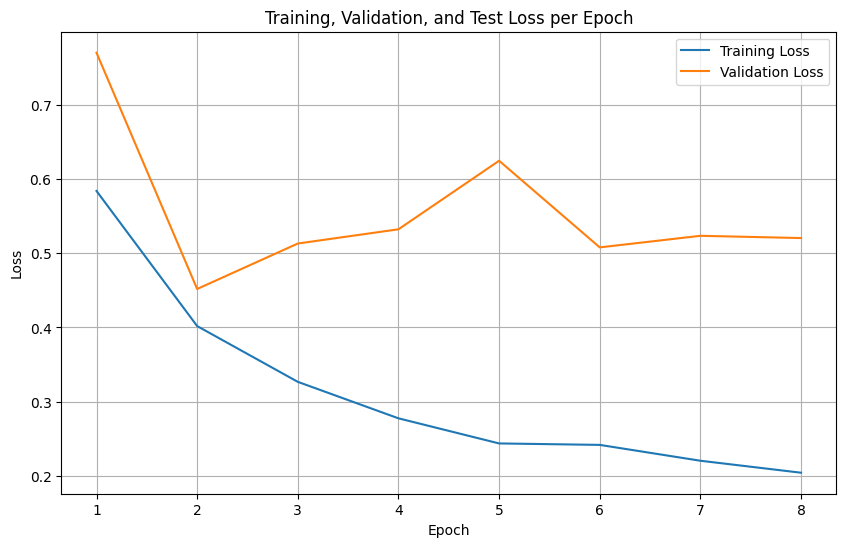

In [8]:
# New Cell 6: Test Loss Calculation and Loss Visualization (Matplotlib Only)

# Define test directory and check if it exists
TEST_DIR = f"{DATASET_ROOT}/test"  # Assuming test folder exists
test_exists = Path(TEST_DIR).is_dir()

# Function to compute test loss
@torch.no_grad()
def compute_test_loss(model, test_loader, criterion, device):
    model.eval()
    test_loss, n = 0, 0
    for x, y in test_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        test_loss += loss.item() * bs
        n += bs
    return test_loss / n if n > 0 else 0

# Compute test loss if test directory exists
test_loss = None
if test_exists:
    # Create test dataset and loader with same transforms as validation
    test_ds = datasets.ImageFolder(str(TEST_DIR), transform=val_tfms)
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS, pin_memory=(device.type == "cuda")
    )
    # Compute test loss
    test_loss = compute_test_loss(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}")
else:
    print("Test directory not found. Skipping test loss calculation.")

# Plot losses using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", color="#1f77b4")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", color="#ff7f0e")
if test_loss is not None:
    plt.axhline(y=test_loss, color="#2ca02c", linestyle="--", label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
@torch.no_grad()
def predict(image_path, checkpoint_path=CHECKPOINT_PATH):
    with open(CLASS_MAP_JSON, "r", encoding="utf-8") as f:
        idx_to_class_local = json.load(f)
    num_classes = len(idx_to_class_local)

    try:
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    except Exception:
        m = models.resnet18(pretrained=True)
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    m.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
    m.eval()

    # use the same val transforms
    img = Image.open(image_path).convert("RGB")
    x = val_tfms(img).unsqueeze(0)
    logits = m(x)
    probs = F.softmax(logits, dim=1).squeeze(0).tolist()
    pred_idx = int(np.argmax(probs))
    return idx_to_class_local[str(pred_idx)], probs

# Example:
# pred, probs = predict(r"path\to\some\image.jpg"); pred, probs[:2]
